In [234]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statistics
from get_bounds import *
from plotting_utility import *
from misc_utility import *
from system_scoring import *

### Grid Points Load (output from scoring.ipynb)
Grid Points are now scored in `scoring.ipynb`.

In [235]:
YYZ_GridPoints = pd.read_csv('../res/grid_points/yyz_grid_points_0.5.csv', sep = ',')
PT_DENSITY = len(YYZ_GridPoints["lat"].unique())

### Clustered Grid Points Load (output from clustering.ipynb)
Clustered Grid Points (a subset of Grid Points) are now scored in `clustering.ipynb`.

In [236]:
YYZ_Clustered_GridPoints = pd.read_csv('../res/grid_points/yyz_clustered_grid_points.csv', sep = ',')
NUM_CLUSTERS = len(YYZ_Clustered_GridPoints["cluster"].unique())

### Parameters

In [237]:
INTERCHANGE_CANDIDATE_BONUS_FACTOR = 5
INTERCHANGE_CANDIDATE_BONUS_DECAY = 100
POLY_REGRESSION_ORDER = 5
NUMBER_INTERCHANGE_CANDIDATES = 2
STATION_MIN_DISTANCE = 0.9
INTERCHANGE_MIN_DISTANCE = 5

### Regression

In [238]:
def linearRegression(scores):
    # step 1: don't use points that are very small (threshold)
    threshold = statistics.median(scores['score'])
    thresholded_scores = scores.loc[scores['score'] >= threshold]
    #print(thresholded_scores)

    regr = LinearRegression()
    lats = thresholded_scores["lat"].values.reshape(-1, 1)
    longs = thresholded_scores["long"].values.reshape(-1, 1)
    regr.fit(lats, longs, thresholded_scores["score"]) # Score is Squared because sample_weight is square rooted thresholded_scores["score"]
    x_begin = lats[0]
    x_end = lats[-1]
    y_begin = regr.predict(x_begin.reshape(1, -1)).item()
    y_end = regr.predict(x_end.reshape(1, -1)).item()

    return (x_begin.item(), x_end.item(), y_begin, y_end)

In [239]:
def polynomialRegression(scores, degree, upperLatBound, bottomLatBound):
    poly = PolynomialFeatures(degree, include_bias=False)
    poly_features = poly.fit_transform(scores["lat"].values.reshape(-1, 1))
    poly_reg_model = LinearRegression().fit(poly_features, scores["long"], scores["score"])
    # = scores['lat'].unique()
    x = np.linspace(scores['lat'].min(), scores['lat'].max(), PT_DENSITY)
    #x = np.arange(bottomLatBound, upperLatBound, round((upperLatBound-bottomLatBound)/PT_DENSITY, 4))
    y = poly_reg_model.predict(poly.fit_transform(x.reshape(-1, 1)))
    return (x, y, poly_reg_model.intercept_, poly_reg_model.coef_)

In [240]:
def getLine(scores, upper, bottom, left, right):
    [*line, line_intercept, line_coefficients] = polynomialRegression(scores, POLY_REGRESSION_ORDER, upper, bottom)
    line = trimOutOfBounds(line, upper, bottom, left, right)
    line = snapLongToGrid(line, left, right, PT_DENSITY)
    return (line, line_intercept, line_coefficients)

### Query Functions

In [241]:
# Gets the points associated with the n highest scores of the line, separated by at least dist
# Does not guarantee that n highest scores will be returned, if restricted by dist. Guarantees at MOST n scores returned.
def getHighestNScorePointsWithMinDist(pts, n, dist, exclusions=pd.DataFrame()):
    sortedPoints = pts.sort_values(by=['score'], ascending=False)
    highestPoints = pd.DataFrame()

    for idx, p in sortedPoints.iterrows():
        if len(highestPoints) >= n:
            break

        previousPoint = (highestPoints.iloc[-1]["lat"], highestPoints.iloc[-1]["long"]) if len(highestPoints) > 0 else (-90,-90)
        currentPoint = (p["lat"], p["long"])
        delta = getDistance(previousPoint, currentPoint)

        if delta >= dist:
            flag = False
            for excIdx, excPoint in exclusions.iterrows():
                if (getDistance((excPoint["lat"], excPoint["long"]), currentPoint) < dist):
                    flag = True
                    break
            if (not flag):
                highestPoints = highestPoints.append(p)

    return highestPoints

In [242]:
def getGridPointsFromLine(scores, line):
    numPoints = len(line[0])
    lineGridPoints = pd.DataFrame()

    for index in range(0, numPoints):
        lati = line[0][index]
        longi = line[1][index]

        scoreIndex = scores.loc[(abs(scores["lat"] - lati) <= 0.005) & (abs(scores["long"] - longi) <= 0.005)].index.values
        if len(scoreIndex) > 0:
            lineGridPoints = lineGridPoints.append(scores.iloc[scoreIndex[0]])

    return lineGridPoints

### Line Generation

In [243]:
# This function generates the lines for the system, and returns the lines in [[lats], [longs]] format
# Also returns the interchange candidates (what possibly can be an interchange) as an array of DataFrames
def generateLines(gridPoints, clusterGridPointsArray, upperBound, bottomBound, leftBound, rightBound):
    lines = []
    interchangeCandidates = pd.DataFrame()
    for i in range(NUM_CLUSTERS):
        clusterGridPointsArray[i] = clusterGridPointsArray[i].append(interchangeCandidates)

        # Decay previous interchange Candidates
        if len(interchangeCandidates) > 0:
            interchangeCandidates['score'] = interchangeCandidates['score'].div(INTERCHANGE_CANDIDATE_BONUS_DECAY)

        [line, _, _] = getLine(clusterGridPointsArray[i], upperBound, bottomBound, leftBound, rightBound)
        lines.append(line)
        linePoints = getGridPointsFromLine(gridPoints, line)
        highestPoints = getHighestNScorePointsWithMinDist(linePoints, NUMBER_INTERCHANGE_CANDIDATES, INTERCHANGE_MIN_DISTANCE, interchangeCandidates)
        highestPoints = highestPoints.assign(score=highestPoints['score'] * INTERCHANGE_CANDIDATE_BONUS_FACTOR)
        interchangeCandidates = interchangeCandidates.append(highestPoints)

        # Code to plot how the subway system is built
        interchangeCandidatePoints = [(interchangeCandidates["lat"].to_numpy(), interchangeCandidates["long"].to_numpy())]
        plotHeatmapPoints(gridPoints, lines + interchangeCandidatePoints, PT_DENSITY)
    return (lines, interchangeCandidates)

In [244]:
def splitGridPointsByClusters(gridPointsWithCluster):
    gridPointClusterArray = []
    for i in range(NUM_CLUSTERS):
        gridPointClusterArray.append(gridPointsWithCluster.loc[gridPointsWithCluster['cluster'] == i])
    return gridPointClusterArray

### Station Generation

In [245]:
# This function generates the stations for a line and returns them in an array
#line numbers are 0 indexed
#distance in km
def generateStationsOnLine(statDistance, subwayLines, lineNum):
    stations = []
    size = len(subwayLines[lineNum][0])

    lati = subwayLines[lineNum][0][0]
    longi = subwayLines[lineNum][1][0]

    stationCor = (lati, longi)
    placeStation = stationCor

    d = {'lat': [lati], 'long': [longi]}
    df = pd.DataFrame(data=d)

    for index in range(0, size - 1):

        lati2 = subwayLines[lineNum][0][index + 1]
        longi2 = subwayLines[lineNum][1][index + 1]

        nextStation = (lati2, longi2)

        distance = getDistance(nextStation, placeStation)

        if distance >= statDistance:

            new_row = {'lat': lati2, 'long': longi2}
            df = df.append(new_row, ignore_index=True)

            placeStation = nextStation


    #convert data frame to numpy array to append to list so we can plot
    lineStat = (df['lat'].values, df['long'].values)

    stations.append(lineStat)

    #return the new set of points
    return stations

In [273]:
#lineNum is not 0 indexed
def generateStationsInSystem(lines, statDistance):
    stationsInSystem = []
    for idx in range(0, NUM_CLUSTERS):
        stationsInSystem += generateStationsOnLine(statDistance,lines, idx)
    return stationsInSystem

### Toronto (YYZ)

In [247]:
[YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound] = getBounds(YYZ_GridPoints['lat'], YYZ_GridPoints['long'], 4)

In [248]:
# YYZ_Cluster_GP_Array is an array with each line being its own cluster's grid points
YYZ_Cluster_GP_Array = splitGridPointsByClusters(YYZ_Clustered_GridPoints)

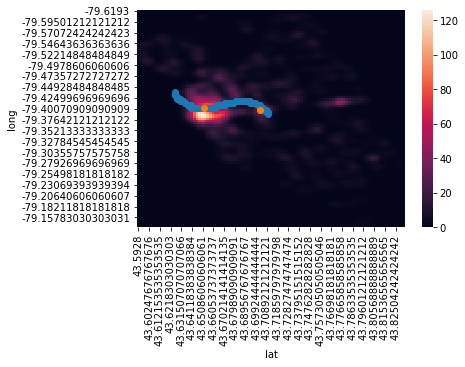

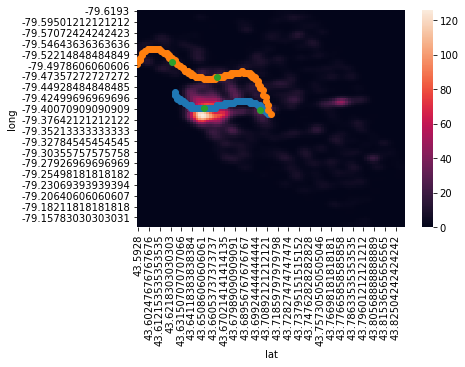

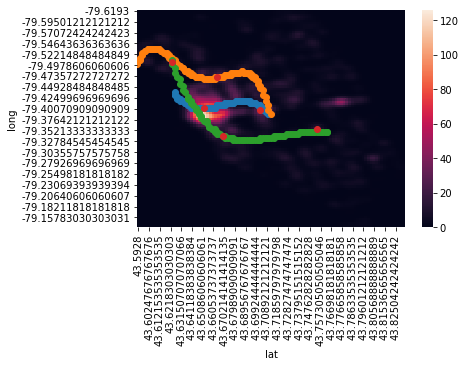

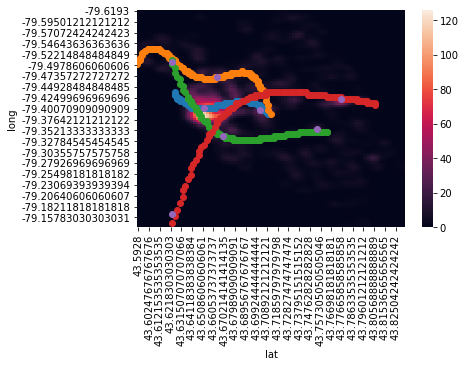

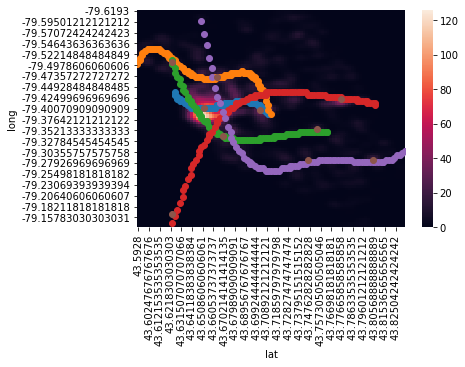

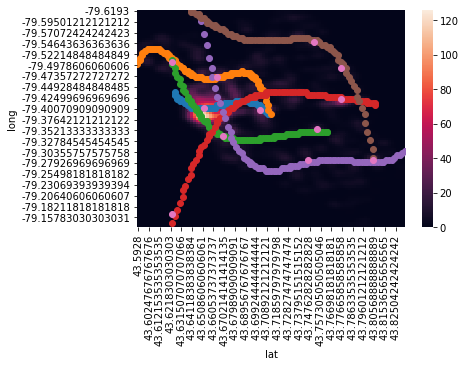

In [249]:
YYZ_Lines, YYZ_Interchange_Candidates = generateLines(
    YYZ_GridPoints, YYZ_Cluster_GP_Array, YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound
)

<AxesSubplot:xlabel='lat', ylabel='long'>

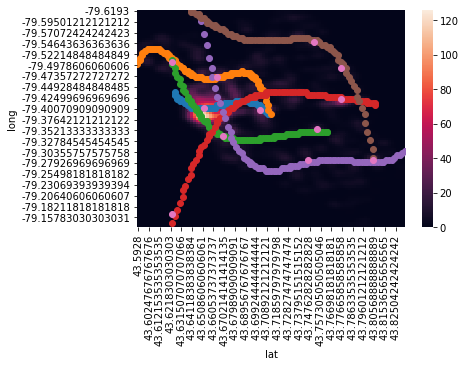

In [250]:
# Draw the System
interchangeCandidatePoints = [(YYZ_Interchange_Candidates["lat"].to_numpy(), YYZ_Interchange_Candidates["long"].to_numpy())]
plotHeatmapPoints(YYZ_GridPoints, YYZ_Lines + interchangeCandidatePoints, PT_DENSITY)

In [274]:
YYZ_Stations = generateStationsInSystem(newLines, STATION_MIN_DISTANCE)

<AxesSubplot:xlabel='lat', ylabel='long'>

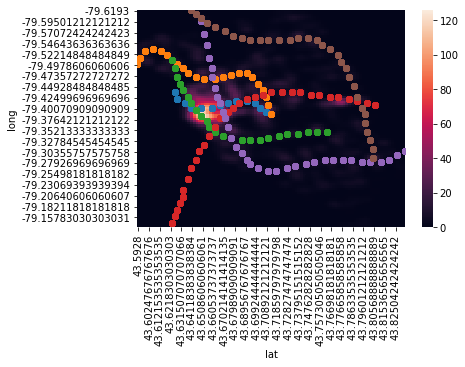

In [275]:
plotHeatmapPoints(YYZ_GridPoints, YYZ_Stations, PT_DENSITY)

In [254]:
YYZ_Lines

[(array([43.62666869, 43.62752396, 43.62837923, 43.6292345 , 43.63008977,
         43.63094504, 43.63180031, 43.63265558, 43.63351085, 43.63436612,
         43.63522139, 43.63607666, 43.63693193, 43.6377872 , 43.63864247,
         43.63949773, 43.640353  , 43.64120827, 43.64206354, 43.64291881,
         43.64377408, 43.64462935, 43.64548462, 43.64633989, 43.64719516,
         43.64805043, 43.6489057 , 43.64976097, 43.65061624, 43.65147151,
         43.65232678, 43.65318205, 43.65403732, 43.65489259, 43.65574786,
         43.65660313, 43.6574584 , 43.65831367, 43.65916894, 43.66002421,
         43.66087948, 43.66173475, 43.66259002, 43.66344529, 43.66430056,
         43.66515583, 43.6660111 , 43.66686637, 43.66772164, 43.66857691,
         43.66943218, 43.67028745, 43.67114272, 43.67199799, 43.67285326,
         43.67370853, 43.6745638 , 43.67541907, 43.67627434, 43.67712961,
         43.67798488, 43.67884015, 43.67969542, 43.68055069, 43.68140596,
         43.68226123, 43.6831165 , 43.

In [ ]:
lines = YYZ_Lines
gridPoints = YYZ_GridPoints
MAX_SCORING_DISTANCE = 1
LINE_PT_THRESHOLD = 5


newLines = []

gp = list(zip(list(gridPoints["lat"]), list(gridPoints["long"]), list(gridPoints["score"])))

for line in lines:
    keptStationsLat = np.empty(0)
    keptStationsLong = np.empty(0)
    for station in zip(line[0], line[1]):
        includedScores = 0
        for point in gp:
            #if point[2] != 0 and la.norm([point[0] - station[0], point[1] - station[1]]) < MAX_SCORING_DISTANCE:
            if getDistance((point[0], point[1]), station) < MAX_SCORING_DISTANCE:
                includedScores += point[2]
        if (includedScores >= LINE_PT_THRESHOLD):
            keptStationsLat = np.append(keptStationsLat, line[0])
            keptStationsLong = np.append(keptStationsLong, line[1])
    newLines.append((keptStationsLat, keptStationsLong))
newLines

### Export Cells

In [253]:
systemScore, lineScores = scoreSystem(YYZ_GridPoints, YYZ_Stations)
systemScore, lineScores

StatisticsError: mean requires at least one data point

In [ ]:
#definitely a better way to do this
numStations = 0
for line in YYZ_Stations:
    for station in zip(line[0], line[1]):
        numStations += 1

numStations

In [ ]:
import json
import random

def getDarkColour():
    r = random.randint(0, 128)
    g = random.randint(0, 128)
    b = random.randint(0, 128)
    hex_code = "#{:02x}{:02x}{:02x}".format(r, g, b)
    return hex_code


obj = {
    "lines": []
}
for idx, line in enumerate(YYZ_Lines):
    stations = []

    df = pd.DataFrame()
    df['lat'] = YYZ_Stations[idx][0]
    df['long'] = YYZ_Stations[idx][1]

    for pt in zip(line[0], line[1]):

        match = (df['lat'] == pt[0]) & (df['long'] == pt[1])

        if match.any():
            stat = True
        else:
            stat = False

        stations.append({
            "lat": pt[0],
            "long": pt[1],
            "station": stat
        })
    lineObj = {
        "line_name": idx,
        "colour": getDarkColour(),
        "stations": stations
    }
    obj["lines"].append(lineObj)

with open('../res/output/yvr.json', 'w') as fp:
    json.dump(obj, fp)

In [ ]:
YYZ_Lines